In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [2]:
df = pd.read_csv("../data/preprocessed.csv")

In [5]:
df.head()

,Unnamed: 0,Area,Country code,Year,Area type,Continent,Ember region,EU,OECD,G20,G7,ASEAN,Category,Subcategory,Variable,Unit,Value,YoY absolute change,YoY % change
0,66,Afghanistan,AFG,2001,Country,Asia,Asia,0.0,0.0,0.0,0.0,0.0,Capacity,Aggregate fuel,Clean,GW,0.19,0.0,0.0
1,67,Afghanistan,AFG,2001,Country,Asia,Asia,0.0,0.0,0.0,0.0,0.0,Capacity,Aggregate fuel,Fossil,GW,0.03,0.0,0.0
2,68,Afghanistan,AFG,2001,Country,Asia,Asia,0.0,0.0,0.0,0.0,0.0,Capacity,Aggregate fuel,Gas and Other Fossil,GW,0.03,0.0,0.0
3,69,Afghanistan,AFG,2001,Country,Asia,Asia,0.0,0.0,0.0,0.0,0.0,Capacity,Aggregate fuel,"Hydro, Bioenergy and Other Renewables",GW,0.19,0.0,0.0
4,70,Afghanistan,AFG,2001,Country,Asia,Asia,0.0,0.0,0.0,0.0,0.0,Capacity,Aggregate fuel,Renewables,GW,0.19,0.0,0.0


In [4]:
# Filter relevant categories
categories = ['Electricity generation', 'Electricity demand', 'Power sector emissions']
variables = ['Total Generation', 'Demand', 'Total emissions']

In [6]:
# Create a new DataFrame for clustering
df_cluster = df[(df['Category'].isin(categories)) & (df['Variable'].isin(variables))]

# Pivot the data to have countries as rows and variables as columns
df_pivot = df_cluster.pivot_table(values='Value', index='Area', columns='Variable', aggfunc='sum')

# Drop any rows with missing values
df_pivot = df_pivot.dropna()

In [11]:
# Normalize the data
scaler = StandardScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_pivot), columns=df_pivot.columns, index=df_pivot.index)

# Perform k-means clustering
n_clusters = 5  # You can adjust this number
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_normalized['Cluster'] = kmeans.fit_predict(df_normalized)

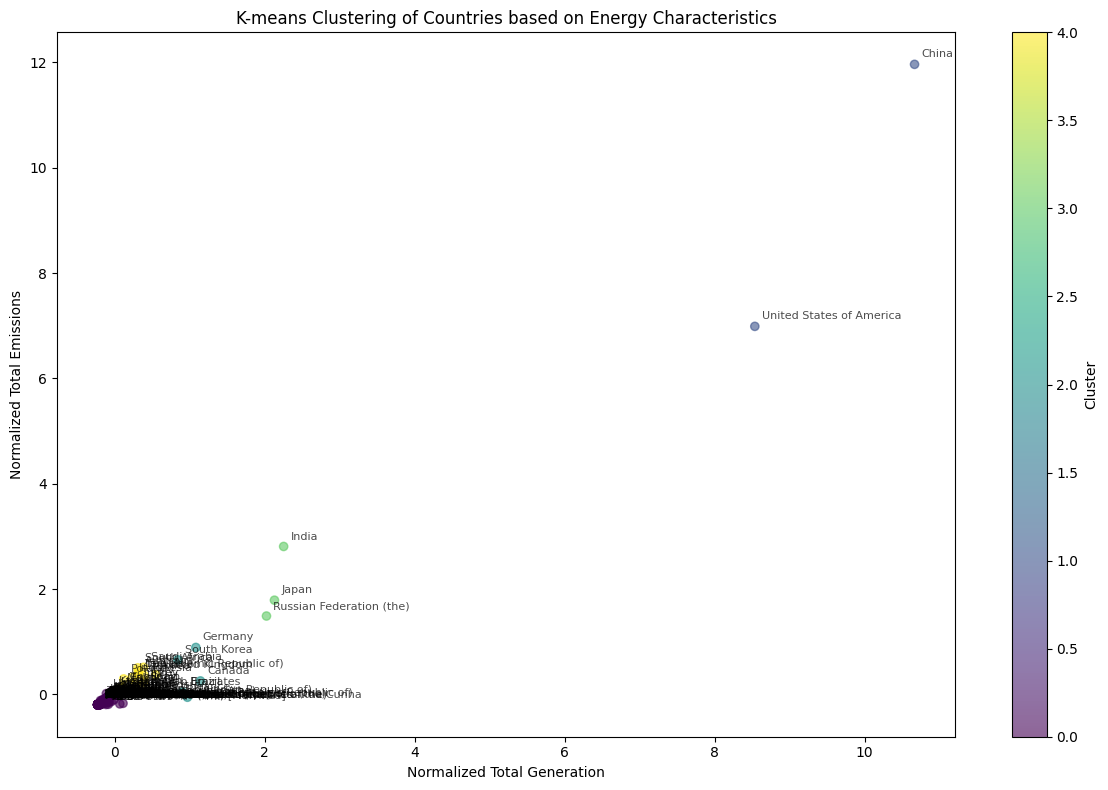

Cluster Centers:
Variable         Demand  Total Generation  Total emissions
0            408.951230        407.268021       173.229144
1         105018.655000     104730.840000     61949.330000
2          12598.224000      12940.648000      3553.430000
3          25069.563333      25170.310000     14248.943333
4           5276.142353       5202.604706      2999.314706

Countries in Cluster 0:
['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Austria', 'Azerbaijan', 'Bahamas (the)', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia Herzegovina', 'Botswana', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Cayman Islands (the)', 'Central African Republic (the)', 'Chad', 'Chile', 'Colombia', 'Comoros (the)', 'Congo (the Democratic Republic of the)', 'Congo (the)', 'Cook Islands (the)', 'Costa Rica', "

In [12]:
# Visualize the clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_normalized['Total Generation'], 
                      df_normalized['Total emissions'], 
                      c=df_normalized['Cluster'], 
                      cmap='viridis', 
                      alpha=0.6)

# Add country labels
for idx, row in df_normalized.iterrows():
    plt.annotate(idx, (row['Total Generation'], row['Total emissions']), 
                 xytext=(5, 5), textcoords='offset points', fontsize=8, 
                 alpha=0.7)

plt.xlabel('Normalized Total Generation')
plt.ylabel('Normalized Total Emissions')
plt.title('K-means Clustering of Countries based on Energy Characteristics')
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

# Print cluster centers
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=df_pivot.columns)
print("Cluster Centers:")
print(cluster_centers_df)

# Print countries in each cluster
for i in range(n_clusters):
    print(f"\nCountries in Cluster {i}:")
    print(df_normalized[df_normalized['Cluster'] == i].index.tolist())

In [14]:
# Function to compute clustering scores
def compute_scores(data, max_clusters=10):
    silhouette_scores = []
    ch_scores = []
    db_scores = []
    inertias = []

    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        
        silhouette_scores.append(silhouette_score(data, cluster_labels))
        ch_scores.append(calinski_harabasz_score(data, cluster_labels))
        db_scores.append(davies_bouldin_score(data, cluster_labels))
        inertias.append(kmeans.inertia_)

    return silhouette_scores, ch_scores, db_scores, inertias

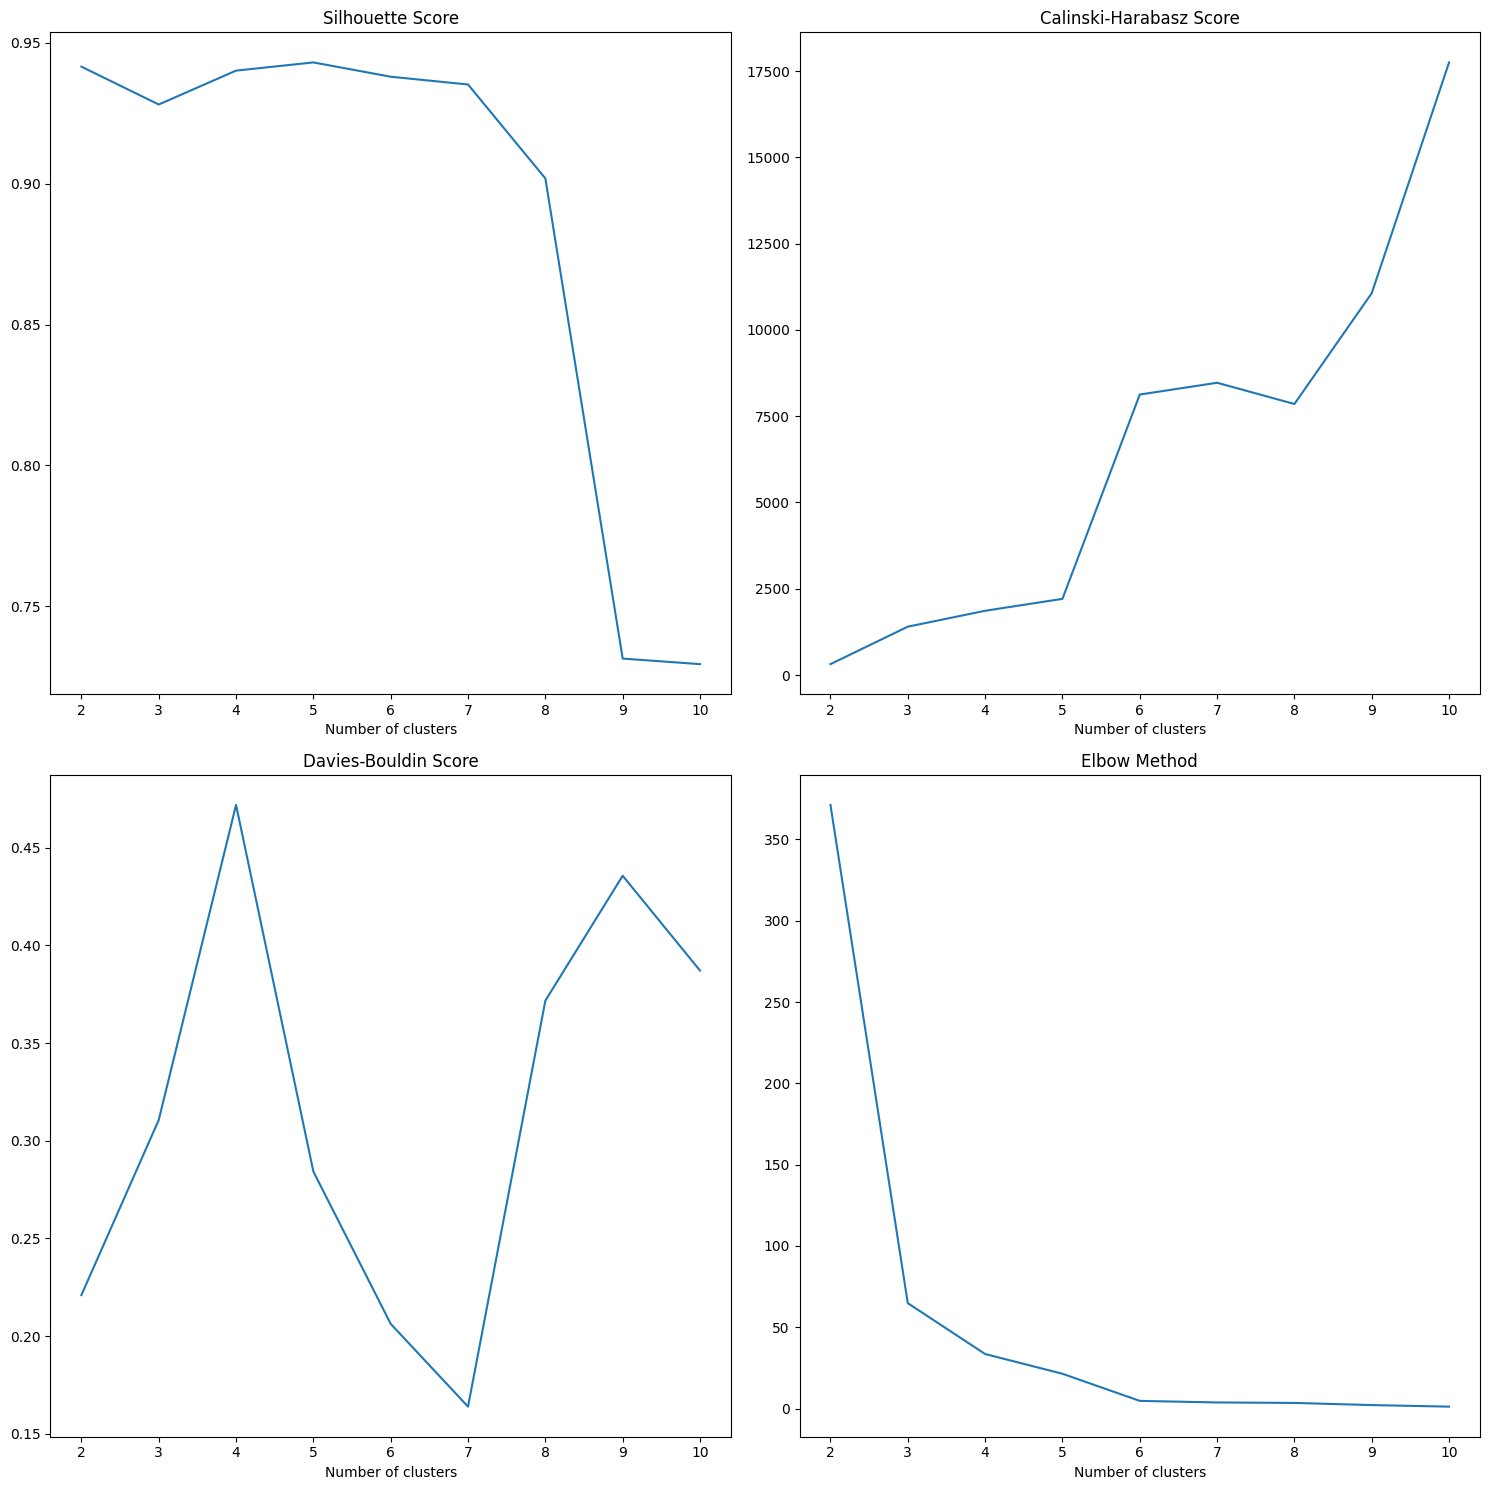

Best Silhouette Score: 0.9430 (n_clusters = 5)
Best Calinski-Harabasz Score: 17748.7942 (n_clusters = 10)
Best Davies-Bouldin Score: 0.1639 (n_clusters = 7)


In [15]:
# Compute scores
silhouette_scores, ch_scores, db_scores, inertias = compute_scores(df_normalized)

# Plot the results
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

axs[0, 0].plot(range(2, len(silhouette_scores) + 2), silhouette_scores)
axs[0, 0].set_title('Silhouette Score')
axs[0, 0].set_xlabel('Number of clusters')

axs[0, 1].plot(range(2, len(ch_scores) + 2), ch_scores)
axs[0, 1].set_title('Calinski-Harabasz Score')
axs[0, 1].set_xlabel('Number of clusters')

axs[1, 0].plot(range(2, len(db_scores) + 2), db_scores)
axs[1, 0].set_title('Davies-Bouldin Score')
axs[1, 0].set_xlabel('Number of clusters')

axs[1, 1].plot(range(2, len(inertias) + 2), inertias)
axs[1, 1].set_title('Elbow Method')
axs[1, 1].set_xlabel('Number of clusters')

plt.tight_layout()
plt.show()

# Print the best scores
print(f"Best Silhouette Score: {max(silhouette_scores):.4f} (n_clusters = {silhouette_scores.index(max(silhouette_scores)) + 2})")
print(f"Best Calinski-Harabasz Score: {max(ch_scores):.4f} (n_clusters = {ch_scores.index(max(ch_scores)) + 2})")
print(f"Best Davies-Bouldin Score: {min(db_scores):.4f} (n_clusters = {db_scores.index(min(db_scores)) + 2})")